(i-sasimovich-20, 15.01.2022)

# Финальный проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

* В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
* Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
* Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

* shared/problem1-reg_data.csv – данные о времени регистрации
* shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

####  Изучаем данные

In [1]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from tqdm.auto import tqdm
import scipy
from scipy.stats import norm
from scipy.stats import levene
from scipy.stats import chi2_contingency, chi2
import scipy.stats as stats
# import requests
# import json 
# from urllib.parse import urlencode 

In [2]:
reg_df = pd.read_csv(r'C:\Users\Ihar237\01. karpov.courses\13 Финальный проект/problem1-reg_data.csv', sep=';')
auth_df = pd.read_csv(r'C:\Users\Ihar237\01. karpov.courses\13 Финальный проект/problem1-auth_data.csv', sep=';')

In [3]:
reg_df.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
# Изучим DataFrame.Посмотрим типы данных.
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [5]:
# Посмотрим есть ли пропущенные значения в данных
miss_reg_df = reg_df.isna().sum()
miss_reg_df[miss_reg_df > 0]

Series([], dtype: int64)

In [6]:
auth_df.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [7]:
# Посмотрим типы данных.
auth_df.dtypes

auth_ts    int64
uid        int64
dtype: object

In [8]:
# Проверим на наличие пропущенных значений.
auth_df.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [9]:
auth_df.shape

(9601013, 2)

In [10]:
# Видим, что даты в обоих датафреймах имеют формат unix epoch, что  неудобно для восприятия, поэтому переведём его в datetime, добавив новые колонки.

reg_df = reg_df.assign(
    reg_dt=pd.to_datetime(reg_df['reg_ts'], unit='s')
)

auth_df = auth_df.assign(
    auth_dt=pd.to_datetime(auth_df['auth_ts'], unit='s')
)

print(f'Registration data "head":\n{reg_df.head()}')
print('-------------- --------------')
print(f'Authorization data "head":\n{auth_df.head()}')

Registration data "head":
      reg_ts  uid              reg_dt
0  911382223    1 1998-11-18 09:43:43
1  932683089    2 1999-07-22 22:38:09
2  947802447    3 2000-01-13 22:27:27
3  959523541    4 2000-05-28 14:19:01
4  969103313    5 2000-09-16 11:21:53
-------------- --------------
Authorization data "head":
     auth_ts  uid             auth_dt
0  911382223    1 1998-11-18 09:43:43
1  932683089    2 1999-07-22 22:38:09
2  932921206    2 1999-07-25 16:46:46
3  933393015    2 1999-07-31 03:50:15
4  933875379    2 1999-08-05 17:49:39


In [11]:
reg_df.dtypes

reg_ts             int64
uid                int64
reg_dt    datetime64[ns]
dtype: object

In [12]:
auth_df.dtypes

auth_ts             int64
uid                 int64
auth_dt    datetime64[ns]
dtype: object

In [13]:
# Посмотрим на максимальное и минимальное значения даты:
print('MIN date:', reg_df.reg_dt.dt.date.min())
print('MAX date:', reg_df.reg_dt.dt.date.max())

MIN date: 1998-11-18
MAX date: 2020-09-23


In [14]:
# Посмотрим Количество регистраций по годам
reg_df.reg_dt.dt.year.value_counts()

2020    354963
2019    291102
2018    159729
2017     87645
2016     48187
2015     26344
2014     14455
2013      7932
2012      4361
2011      2385
2010      1308
2009       718
2008       394
2007       216
2006       119
2005        65
2004        35
2003        20
2002        10
2001         6
2000         4
1999         1
1998         1
Name: reg_dt, dtype: int64

In [15]:
reg_df.reg_dt.dt.date.quantile([0.05, 0.25, 0.5, 0.75, 0.95])

0.05    2015-09-28
0.25    2018-06-03
0.50    2019-07-30
0.75    2020-04-01
0.95    2020-08-23
Name: reg_dt, dtype: object

Отметим, что данные предоставленны за период более 20 лет. Отсюда возникают вопросы о необходимости и целесообразности анализа такого большого периода, а также корректности данных. Стоит уточнить у моего коллеги менеджера цели и задачи, которые он планирует решать с помощью данного анализа.

### Решение:

In [16]:
''' 
Функция принимающая два DataFrame (a = auth_df; b = reg_df) с датами регистраций
и заходов пользователей в формате timestamp (unix epoch), дату отсчёта (start_date) 
и период (period) в днях, интересующий нас с даты отсчёта. 
''' 

def retention(a, b, start_date, period):
    start = pd.Timestamp(start_date).date()
    finish = start + pd.Timedelta(days = (period + 1)) # +1 день, чтобы отражаемый период (количество дней) отражал в таблице количество дней = period 
    #сводим два дата сета с датами регистрации и аутентификации пользователя
    df = a.merge(b,on='uid', how='left') 
    #переводим секунды в даты
    df['authentication_date'] = pd.to_datetime(df.auth_ts,unit='s').dt.date 
    df['registration_date'] = pd.to_datetime(df.reg_ts,unit='s').dt.date
    #переводим даты аутентификаций в количество дней от регистрации
    df['diff'] = (df.authentication_date - df.registration_date).dt.days 
    df = df[(df.registration_date >= start) & (df.authentication_date <= finish)]   
    # создаем сводную таблицe c  когортами в абсолютных значениях, где строки - дата регистрации, колонки - разница в днях между датой 
    # регистрации и датой авторизации, значения - количетво уникальных id
    df_cohort = df.pivot_table(index='registration_date',columns='diff',values='uid', aggfunc='nunique') 
    #выделяем столбец с днём регистрации пользователей, он же и равен размеру когорты 
    cohort_sizes = df_cohort.iloc[:,0] 
    #делим значения в каждом столбце на количество пользователей в день регистрации
    retention_cohort = df_cohort.divide(cohort_sizes, axis=0) 
    #блок визуализации
    plt.figure(figsize = (20, 18))
    plt.title('Retention', fontsize = 20)
    sns.heatmap(retention_cohort, annot = True, fmt = '.1%',cmap = 'YlGnBu', vmin = 0.0 , vmax = 0.1)
    plt.ylabel('Registration Date')
    plt.xlabel('Cohort period')
    plt.show()

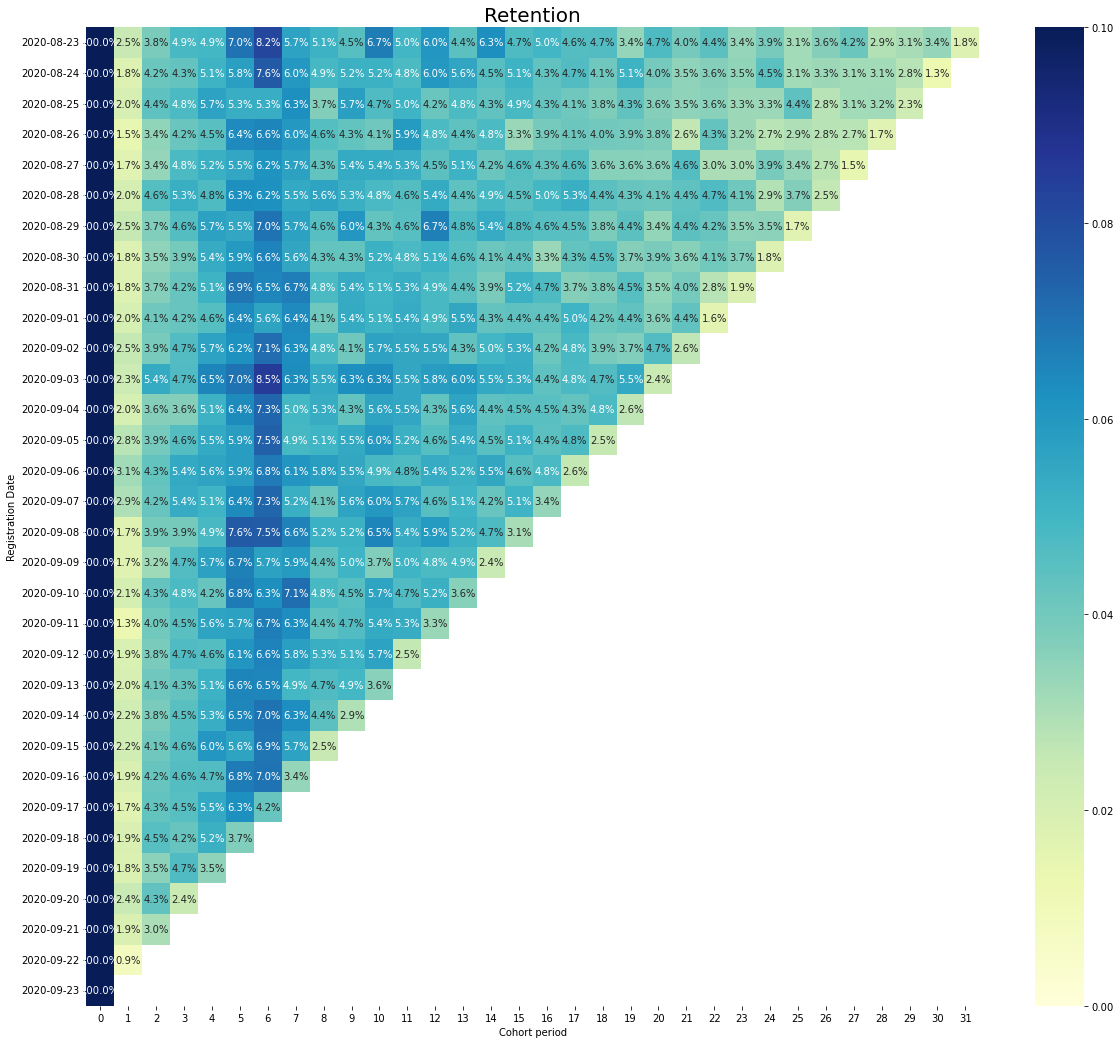

In [17]:
retention(auth_df, reg_df,'2020-08-23',30)

Как мы видим, на следующий день после регистрации в большинстве когорт Retention составляет до 2%, что очень мало. Игра слабо 'цепляет'.

Затем на 2-3 день следует рост примерно до 5%.

В период с 4 по 8 день с даты регистрации Retention составляет  5,7 - 8,5%. Это пик для всех когорт, за которым следует постепенное уменьшение данной метрики.

Причём данный сценарий просматривается почти во всех когортах.

## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 

Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

###  Решение

In [18]:
AB_df = pd.read_csv(r'C:\Users\Ihar237\01. karpov.courses\13 Финальный проект/Проект_1_Задание_2.csv', sep=';')
AB_df.head(3)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a


In [19]:
# Посмотрим информацию о данных.
AB_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [20]:
AB_df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Выясним какая из групп контрольная, т.к. в описании она не указана.
Мы знаем, что в тестовой группе ARPU выше чем в контрольной группе на 5%. Так же мы знаем, что в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
На основании этого определим какая из двух групп является контрольной, а какая тестовой. 

In [21]:
# средний чек
ARPU_A = round(
    AB_df[AB_df.testgroup == "a"].revenue.mean(), 2
)
ARPU_B = round(
    AB_df[AB_df.testgroup == "b"].revenue.mean(), 2
)

print('ARPU_A:', ARPU_A, '|' ,'ARPU_B:', ARPU_B)    
print('ARPU_A / ARPU_B :', round(ARPU_A / ARPU_B, 2),'%') 

ARPU_A: 25.41 | ARPU_B: 26.75
ARPU_A / ARPU_B : 0.95 %


In [22]:
# посмотрим на количество наблюдений в каждой группе:
AB_df.groupby('testgroup').user_id.nunique()

testgroup
a    202103
b    202667
Name: user_id, dtype: int64

In [23]:
# количество платящих игроков в группах
print(
"a:", AB_df[AB_df.testgroup == "a"].query("revenue > 0").user_id.nunique(),
'|',
"b:", AB_df[AB_df.testgroup == "b"].query("revenue > 0").user_id.nunique(),
)

a: 1928 | b: 1805


На основании полученного результата мы можем заключить, что a - контрольная группа и b - тестовая группа. Для удобства восприятия переименуем группы

In [24]:
AB_df = AB_df.replace({'testgroup': {'a': 'control', 'b': 'test'}})
AB_df.head(3)

,user_id,revenue,testgroup
0,1,0,test
1,2,0,control
2,3,0,control


Проверим наши группы на требование к гомогенности диспресий с помощью теста Левена.

Проверяемые гипотезы:
* H0:  дисперсия между группами одинакова.
* H1:  дисперсия между группами не одинакова.

In [25]:
cntrl_g= AB_df.query('testgroup == "control"').revenue
test_g = AB_df.query('testgroup == "test"').revenue

In [26]:
levene(cntrl_g, test_g)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

In [27]:
alpha = 0.05 # уровень значимости
w_stats, p_value = levene(cntrl_g, test_g)
if p_value > alpha :
    print ( "We do not reject the null hypothesis" )
else :
    print ( "Reject the Null Hypothesis" )

We do not reject the null hypothesis


На имеющихся данных, на уровне значимости 5% нет оснований отклонить нулевую гипотезу в пользу альтернативы.

P-value > 0.05 => Результат не позволяет нам отклонить H0. Считаем, что дисперсия между группами одинакова.

Теперь проверим нормальность распределения данных в нутри наших групп. Применим критерий Шапиро-Уилка

Проверяемые гипотезы:
* H0: распределение нормальное
* H1: распределение отличается от нормального

In [28]:
scipy.stats.shapiro(cntrl_g.sample(5000, random_state=17))  

ShapiroResult(statistic=0.008855879306793213, pvalue=0.0)

In [29]:
scipy.stats.shapiro(test_g.sample(5000, random_state=17))  

ShapiroResult(statistic=0.07101637125015259, pvalue=0.0)

На имеющихся данных, в обоих случаях, на уровне значимости 5% есть основания отклонить нулевую гипотезу в пользу альтернативы.

Так как в обоих случаях P-value оказался равным 0, это позволяет нам не принять H0. Для того чтобы удостовериться в ненормальности визуализируем данные в наших дата-сетах. Учитывая удельный вес неплатящих игроков, для наглядности, исключаем нулевые значения в выборках.

In [30]:
cntrl_g1 = AB_df[AB_df.testgroup == "control"].query("revenue > 0").revenue
test_g1 = AB_df[AB_df.testgroup == "test"].query("revenue > 0").revenue

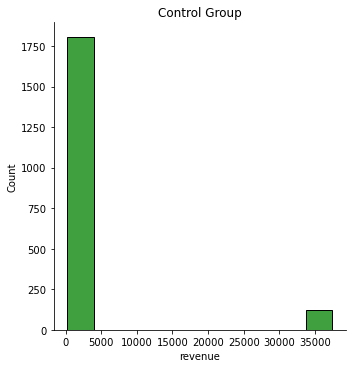

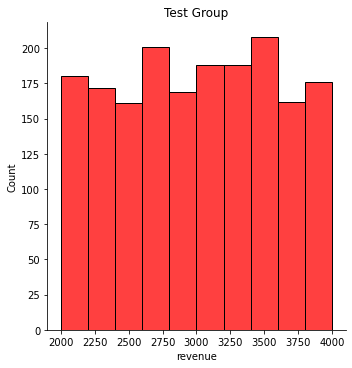

In [31]:
sns.displot(cntrl_g1, bins=10, color='green')
plt.title("Control Group")
plt.show()
sns.displot(test_g1, bins=10, color='red')
plt.title("Test Group")
plt.show()

В полученном результате, мы видим что в контрольной группе слишком большой разрыв в значениях и оно явно распределено не нормально. Распределение тестовой группы также значительно отличается от нормального.

Распределение чеков в тестовой группе гораздо более равномерно. В контрольной же группе большоинство покупателей имеют низкий чек.

Попробуем прологарифмировать значения в обоих датасетах и попробуем их опять визуализировать.

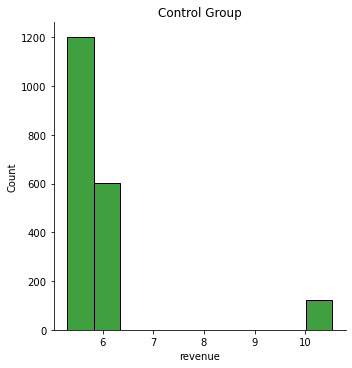

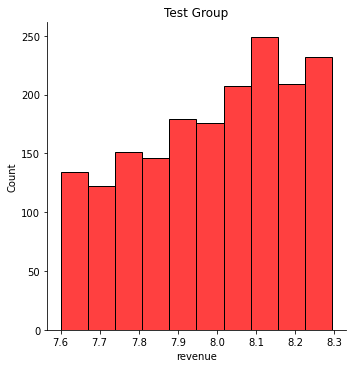

In [32]:
sns.displot(np.log(cntrl_g1), bins=10, color='green')
plt.title("Control Group")
plt.show()
sns.displot(np.log(test_g1), bins=10, color='red')
plt.title("Test Group")
plt.show()

Не смотря на то, что полученные распределения унимодальны и без критических различий в дисперсиях, они сильно отличаются от нормального распределения.

Теперь можем утверждать, что распределение ненормальное в обоих выборках. И отклонение H0 не было ошибкой сэмплирования данных.

Продолжим исследование. Сперва рассмотрим гипотезу о стат-значимости разницы в ARPU. 
Сформулируем две новые гипотезы. 

На выходе получаем две следующие гипотезы:
* H0 - разница между ARPU тестовой и контрольной группы статистически не значима
* H1 - разница между ARPU тестовой и контрольной группы статистически значима

Т.к. данные распределены ненормально, воспользуемся bootstrap.

In [33]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа 
# Данная функция позаимствована с karpov.courses

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,  # чтобы сохранить дисперсию, берем такой же размер выборки
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() < quants.iloc[0][0] or bar.get_x() > quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}


def short_bs_summary(data_column_1, data_column_2):
    mean_diff = data_column_1.mean() - data_column_2.mean()
    bs = get_bootstrap(data_column_1, data_column_2)
    
    print(f'Разница между средними: {round(mean_diff, 3)}')
    print(f'p-value: {bs["p_value"].round(2)}')
    quant_025 = round(bs['quants'][0].min(), 3)
    quant_975 = round(bs['quants'][0].max(), 3)
    print(f'Доверительный интервал: [{quant_025}:{quant_975}]')
    print('Вывод:')
    if bs['p_value'] > 0.05:
        print('Принимаем нулевую гипотезу, разница между показателями не имеет статистическую значимость.')
        return
    print('Отвергаем нулевую гипотезу, разница между показателями имеет статистическую значимость.')
    return

  0%|          | 0/1000 [00:00<?, ?it/s]

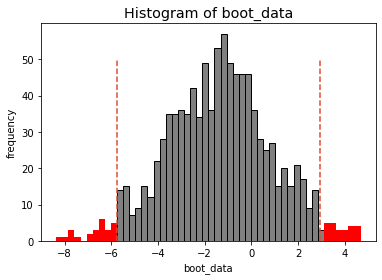

Разница между средними: -1.338
p-value: 0.54
Доверительный интервал: [-5.752:2.953]
Вывод:
Принимаем нулевую гипотезу, разница между показателями не имеет статистическую значимость.


In [34]:
short_bs_summary(cntrl_g, test_g)

Мы не смогли увидеть статистическую разницу в среднем доходе на пользователя между контрольной и тестовой группами после проведённого теста.

Для интереса, проверим себя, применив критерий Манна Уитни, хотя он слишком сложен в интерпретации и имеет ряд других недостатков .

In [35]:
scipy.stats.mannwhitneyu(cntrl_g, test_g)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

В нашем случае результат сходится, так как p-value=0.06, то мы не можем отклонить нулевую гипотезу. Средние значения ARPU статистически значимо не отличаются.

Так основным фактором изменчивости Revenue является количество и качество платящих игроков, проведём такие же тесты с ARPPU:

In [36]:
ARPPU_cntrl = cntrl_g1.mean()
ARPPU_test = test_g1.mean()

print('ARPPU_cntrl:', ARPPU_cntrl, '|', 'ARPPU_test:', ARPPU_test)    
print('ARPPU_cntrl / ARPPU_test :', round(ARPPU_cntrl / ARPPU_test, 2),'%') 

ARPPU_cntrl: 2663.9984439834025 | ARPPU_test: 3003.6581717451522
ARPPU_cntrl / ARPPU_test : 0.89 %


  0%|          | 0/1000 [00:00<?, ?it/s]

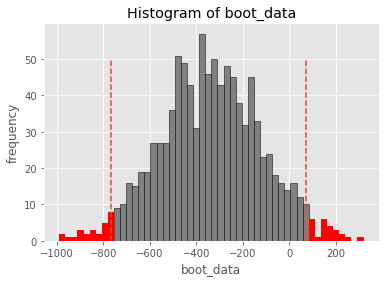

Разница между средними: -339.66
p-value: 0.12
Доверительный интервал: [-766.0:73.117]
Вывод:
Принимаем нулевую гипотезу, разница между показателями не имеет статистическую значимость.


In [37]:
short_bs_summary(cntrl_g1, test_g1)

Опять же, для интереса, проверим себя, применив критерий Манна Уитни

In [38]:
scipy.stats.mannwhitneyu(cntrl_g1, test_g1)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

Сравнение показателей ARPPU контрольной и тестовой группы посредством U-критериея Манна—Уитни, при P-value == 0.05, показало статистически значимые отличия, что отличается от результатов полученных bootstrap. 

Учитывая, что тест Манна—Уитни переводит показатели иследуемого признака в ранговую шкалу, в следствии чего, метрики стали неинтерпретируемыми, а бизнесу всегда нужна конкретика, будем опираться на результаты bootstrap.

Теперь, посмотрим как изменилась конверсия в оплату. Оплатил или не оплатил, является категориальной переменной, поэтому будем использовать ХИ квадрат.

Но для начала, посчитаем конверсию.

In [39]:
# процент купивших (конверсия)
CR_cntrl = round(AB_df[AB_df.testgroup == "control"].query("revenue > 0").user_id.nunique() / 
                 AB_df[AB_df.testgroup == "control"].user_id.nunique() * 100, 2)
CR_test = round(AB_df[AB_df.testgroup == "test"].query("revenue > 0").user_id.nunique() / 
                AB_df[AB_df.testgroup == "test"].user_id.nunique() * 100, 2)

print('CR_cntrl:', CR_cntrl, '|', 'CR_test:', CR_test)   

CR_cntrl: 0.95 | CR_test: 0.89


Видим, что показатель конверсии в контрольной группе превышает тестовый на 6%. 

Определимся с гиппотезами:
* H0 - разница между CR тестовой и контрольной группы статистически не значима. Наши нововведения не оказывают никакого влияния. 
* H1 - разница между CR тестовой и контрольной группы статистически значима. Влияние есть.

In [40]:
# Затем преобразуем числовую переменную в категориальную платящий/не платящий
AB_df['buy'] = np.where(AB_df.revenue > 0, 'payer', 'slacker')
AB_df.head(3)

,user_id,revenue,testgroup,buy
0,1,0,test,slacker
1,2,0,control,slacker
2,3,0,control,slacker


In [41]:
pd.crosstab(AB_df.buy, AB_df.testgroup)

testgroup,control,test
buy,,
payer,1928,1805
slacker,200175,200862


In [42]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(AB_df.buy, AB_df.testgroup))
print('stat =', stat, ' | ', 'p-value =', p)

stat = 4.374729521260405  |  p-value = 0.03647561892312613


In [43]:
# Сравним значение стаистики с нужным порогом
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


In [44]:
# Сравним p-value с заданным порогом значимости
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


На имеющихся данных, на уровне значимости 5% есть основания отклонить нулевую гипотезу в пользу альтернативы.

P < 0.05, следовательно мы можем сделать вывод, что полученный результат является стат значимым. Взаимосвзяь  между переменными есть. Конверсия в не платящего пользователя статистически значимо снизилась по сравнению с конверсией в платящего пользователя в контрольной группе. Следовательно, предложения показынные в контрольной группе были более привлекательными.

### Выводы по итогу анализа теста мы можем сделать следующие:

Между группами статистически значимая разница в конверсии в платящего (в пользу контроля).
Мы не смогли увидеть статистическую разницу в среднем доходе на пользователя (в т.ч. и платящего) между контрольной и тестовой группами после проведённого теста.

Также у нас нет информации за какой период предоставленны данные, правильно ли произведёны выборки. 

Значения Revenue в абсолютных значениях и их распределение сильно различаются между тестовой и контрольной группой. В контрольной группе мы можем явно выделить Китов и основной костяк - пользователей предпочитающих тратить немного денег, в то время как, в тестовой группе пользователи тратят усреднённое количество денег. Учитывая это раскатывать акцию на всех пользователей слишком рисковано, т.к. это может кардинально поменять источники дохода.

#### Решение - не раскатывать тестируемую акцию на всю аудиторию. 

Так же необходимо посмотреть показатель Retention, вполне возможно, что нынешние Киты единожды вкладывают крупную сумму и в результате в долгосрочной перспективе будут приносить меньше доходов в сравнении с другими сегментами, возможно такие крупные вложения делают игру для них слишком простой, из-за чего они могут быстро терять интерес к игре.

## Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Ответ

На мой взгляд,  в первую очередь целесообразно опираться на те метрики, которые непосредственно связаны с акцией и ее целью, например, количество проданных уникальных предметов во время каждой отдельной акции, количество проданных дополнительных монет/бонусов доступных для преобретения внутри игры, изменения в составе "продуктовой корзины" пользователей.

Для оценки успешности проведения игрового-ивента я предлагаю использовать следующие метрики:

* Retention
* ARPU/ARPPU
* Paying share
* Average Check
* LTV
* DAU, WAU, MAU
* Average & Median Time for completion - среднее и медианное количество времени необходимое для прохождения уровней
* Average & Median Session Time - среднее и медианное время сессии
* количество пользователей дошедшее до определенного уровня

Будет полезно посмотреть на проходимость уровней - построить воронку с процентом игроков прошедших уровни. При равномерном усложнении уровней процент игроков будет уменьшаться стабильно, однако на особенно сложных уровнях процент оставшихся игроков будет уменьшаться резко.

Естественнно, все метрики надо смотреть в динамике, замерять до акции, во время акции и после, до возвращения к примерно тем же показателям, которые были до акции (после акции возможно временное снижение интереса как к покупкам, так и к игре в целом).

При изменении механики описанным образом я бы дополнительно смотрел:
* среднее и медианное количество попыток у прошедших ивент пользователей;
* среднее время прохождения всех уровней (для сравнения с прошлой механикой, возможно новая механика не так сильно изменит это время);
* насколько уровней назад в среднем откатывался пользователь, который не дошел до конца? Где отвалился? Самые проблемные  уровни?;
* сколько пользователей не откатилось ни на один уровень?;
* сколько людей безвозвратно ушло, после такого ужасного тематического события, в игре?.